# Perception

## Introduction to 3D Perception

### Creating a Point Cloud from RGB-D Data

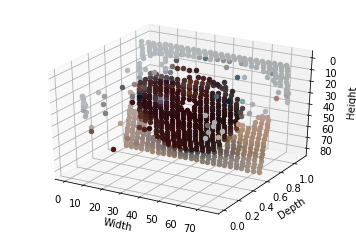

Outputted 728 of the 6552 points
Results produced in 3.89 seconds


In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from time import time

#############################
# Hit Test Run to Visualize #
#############################

# Read in the image and depth map as seperate assets
image_location = '1.png'
depth_map_location = '2.png'

# Load in the images
depth_map = mpimg.imread(depth_map_location)
image = mpimg.imread(image_location)
depth_map = depth_map[:,:,0]

start_time = time()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rows, cols = depth_map.shape

# Send pixels not correctly mapped to the back
# Use 1.1 to send the poorly mapped pixels back 10 percent 
# farther than the farthest correctly mapped point
max_val = depth_map.max() * 1.1

count = 0

# Cut down pixels for time purpose 
# Computations need to be under 30s
pixel_cut = 3 

# Iterate thorugh all the pixels       
for x in range(cols):
    for y in range(rows):
        if (x % pixel_cut == 0 and y % pixel_cut == 0):
            
            # Count points done
            count+=1
            
            # Get point color for pixel
            pixel_color = (image[y,x,0],image[y,x,1],image[y,x,2])
            
            # Get point depth for each particle
            depth = depth_map[y,x]
            
            # Send points not correctly mapped to the back
            if depth == 0:
                depth = max_val
                
            ax.scatter(x, depth, y, c = pixel_color, marker='o')

# Axis Labels
ax.set_xlabel('Width')
ax.set_ylabel('Depth')
ax.set_zlabel('Height')

plt.gca().invert_zaxis()

###########################################
# Play with me to change view rotation!
elevation = 30 # Up/Down
azimuth = 300 # Left/Right
###########################################


ax.view_init(elevation, azimuth)

plt.show() # Uncomment if running on your local machine
print ("Outputted {} of the {} points".format(count,6552))
print ("Results produced in {:04.2f} seconds".format(time()-start_time))

## Clustering for Segmentation

### K-means Playground

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Define a function to generate clusters
def cluster_gen(n_clusters, pts_minmax=(10, 100), x_mult=(1, 4), y_mult=(1, 3), 
                             x_off=(0, 50), y_off=(0, 50)):

    # n_clusters = number of clusters to generate
    # pts_minmax = range of number of points per cluster 
    # x_mult = range of multiplier to modify the size of cluster in the x-direction
    # y_mult = range of multiplier to modify the size of cluster in the y-direction
    # x_off = range of cluster position offset in the x-direction
    # y_off = range of cluster position offset in the y-direction

    # Initialize some empty lists to receive cluster member positions
    clusters_x = []
    clusters_y = []

    # Generate random values given parameter ranges
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)

    # Generate random clusters given parameter values
    for idx, npts in enumerate(n_points):

        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)

    # Return cluster positions
    return clusters_x, clusters_y

In [15]:
# Generate some clusters!
n_clusters = 7
clusters_x, clusters_y = cluster_gen(n_clusters)

# Convert to a single dataset in OpenCV format
data = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()

In [16]:
# Define k-means parameters
# Number of clusters to define
k_clusters = 7
# Maximum number of iterations to perform
max_iter = 10
# Accuracy criterion for stopping iterations
epsilon = 1.0
# Define criteria in OpenCV format
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Call k-means algorithm on your dataset
compactness, label, center = cv2.kmeans(data, k_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [17]:
# Define some empty lists to receive k-means cluster points
kmeans_clusters_x = []
kmeans_clusters_y = []

# Extract k-means clusters from output
for idx in range (k_clusters):
    kmeans_clusters_x.append(data[label.ravel()==idx][:,0])
    kmeans_clusters_y.append(data[label.ravel()==idx][:,1])

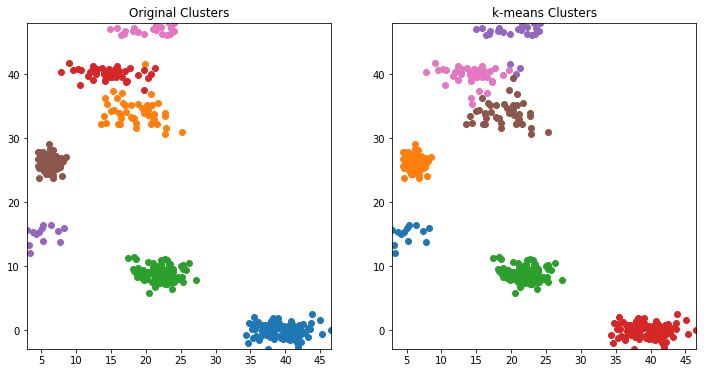

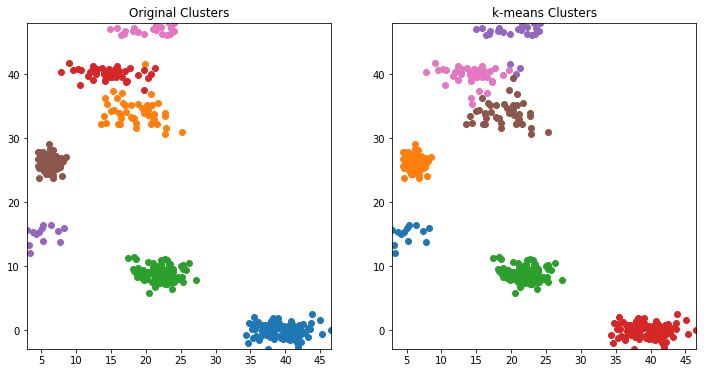

In [19]:
# Plot up a comparison of original clusters vs. k-means clusters
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])
for idx, xpts in enumerate(clusters_x): 
    plt.plot(xpts, clusters_y[idx], 'o')
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.title('Original Clusters')
plt.subplot(122)
for idx, xpts in enumerate(kmeans_clusters_x):
    plt.plot(xpts, kmeans_clusters_y[idx], 'o')
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.title('k-means Clusters')
    
plt.show()

### DBSCAN Algorithm

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN
from extra_functions import cluster_gen

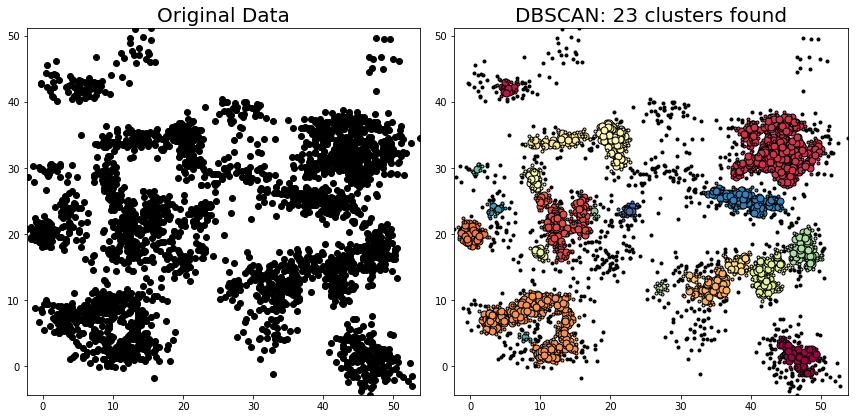

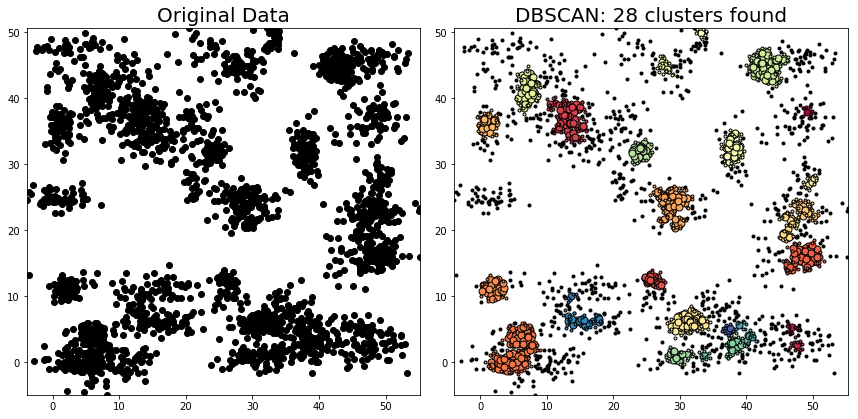

In [24]:
# Generate some clusters!
n_clusters = 50
clusters_x, clusters_y = cluster_gen(n_clusters)
# Convert to a single dataset in OpenCV format
data = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()
# Define max_distance (eps parameter in DBSCAN())
max_distance = 1
db = DBSCAN(eps=max_distance, min_samples=10).fit(data)
# Extract a mask of core cluster members
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Extract labels (-1 is used for outliers)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

# Plot up the results!
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

plt.subplot(122)
# The following is just a fancy way of plotting core, edge and outliers
# Credit to: http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)
plt.show()

## Object Recognition

### Histogram in Action

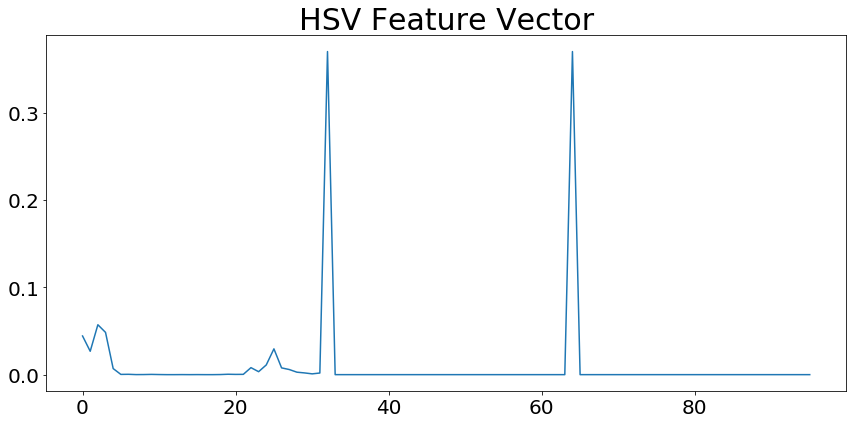

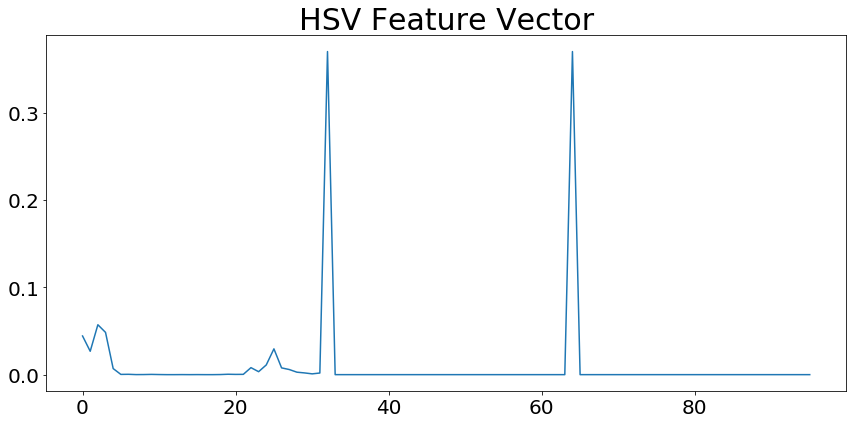

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
image = mpimg.imread('1.png')

    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Convert from RGB to HSV using cv2.cvtColor()
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Compute the histogram of the HSV channels separately
    h_hist = np.histogram(hsv_img[:,:,0], bins=32, range=(0, 256))
    s_hist = np.histogram(hsv_img[:,:,1], bins=32, range=(0, 256))
    v_hist = np.histogram(hsv_img[:,:,2], bins=32, range=(0, 256))
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((h_hist[0], s_hist[0], v_hist[0])).astype(np.float64)
    
    # Normalize the result
    norm_features = hist_features / np.sum(hist_features)
    
    # Return the feature vector
    return norm_features
    
feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if feature_vec is not None:
    fig = plt.figure(figsize=(12,6))
    plt.plot(feature_vec)
    plt.title('HSV Feature Vector', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    fig.tight_layout()
    plt.show()
else:
    print('Your function is returning None...')

### Support Vector Machine

In [1]:
import numpy as np

# Define a function to generate clusters
def cluster_gen(n_clusters, pts_minmax=(100, 500), x_mult=(2, 7), y_mult=(2, 7), 
                             x_off=(0, 50), y_off=(0, 50)):

    # n_clusters = number of clusters to generate
    # pts_minmax = range of number of points per cluster 
    # x_mult = range of multiplier to modify the size of cluster in the x-direction
    # y_mult = range of multiplier to modify the size of cluster in the y-direction
    # x_off = range of cluster position offset in the x-direction
    # y_off = range of cluster position offset in the y-direction

    # Initialize some empty lists to receive cluster member positions
    clusters_x = []
    clusters_y = []
    labels = []
    # Generate random values given parameter ranges
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)

    # Generate random clusters given parameter values
    for idx, npts in enumerate(n_points):

        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)
        labels.append(np.zeros_like(xpts) + idx)

    # Return cluster positions and labels
    return clusters_x, clusters_y, labels

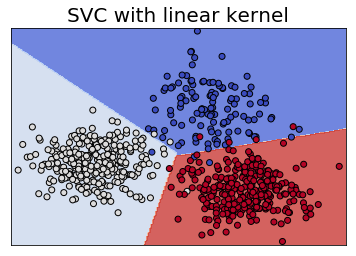

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

np.random.seed(424) # Change the number to generate a different cluster.

n_clusters = 3
clusters_x, clusters_y, labels = cluster_gen(n_clusters)

# Convert to a training dataset in sklearn format
X = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()
y = np.float32((np.concatenate(labels)))

# Create an instance of SVM and fit the data.
ker = 'linear'
svc = svm.SVC(kernel=ker).fit(X, y)

# Create a mesh that we will use to colorfully plot the decision surface
# Plotting Routine courtesy of: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
# Note: this coloring scheme breaks down at > 7 clusters or so

h = 0.2  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # -1 and +1 to add some margins
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Classify each block of the mesh (used to assign its color)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='black')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVC with '+ker+' kernel', fontsize=20)
plt.show()

### SVM Image Classification

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Convert from RGB to HSV using cv2.cvtColor()
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Compute the histogram of the HSV channels separately
    h_hist = np.histogram(hsv_img[:,:,0], bins=nbins, range=bins_range)
    s_hist = np.histogram(hsv_img[:,:,1], bins=nbins, range=bins_range)
    v_hist = np.histogram(hsv_img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((h_hist[0], s_hist[0], v_hist[0])).astype(np.float64)
    # Normalize the result
    norm_features = hist_features / np.sum(hist_features)
    # Return the feature vector
    return norm_features

# Define a function to extract features from a list of images
# Have this function call color_hist()
def extract_features(imgs, hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color_hist() 
        hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(hist_features)
    # Return list of feature vectors
    return features


# Read in car and non-car images
images = glob.glob('data/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
histbin = 32

car_features = extract_features(cars, hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Dataset includes', len(cars), 'cars and', len(notcars), 'not-cars')
print('Using', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC(kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Dataset includes 1196 cars and 1125 not-cars
Using 32 histogram bins
Feature vector length: 96
0.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  0.  1.  1.  0.]
0.00098 Seconds to predict 10 labels with SVC
